In [1]:
import cv2
import dlib
import os

shape_predictor_path = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\shape_predictor_68_face_landmarks (1).dat'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)

def extract_mouth_from_frame(frame, predictor, detector, frame_size=(220, 220)):
    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = detector(gray)
    if len(faces) > 0:
        # Get the first face detected
        face = faces[0]
        # Get the landmarks for the face
        landmarks = predictor(gray, face)
        # Get the coordinates for the mouth region
        mouth_coords = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 68)]
        # Get the bounding box for the mouth region
        x_min = min(mouth_coords, key=lambda x: x[0])[0]
        x_max = max(mouth_coords, key=lambda x: x[0])[0]
        y_min = min(mouth_coords, key=lambda x: x[1])[1]
        y_max = max(mouth_coords, key=lambda x: x[1])[1]
        # Extract the mouth region
        mouth_region = frame[y_min:y_max, x_min:x_max]
        # Resize the mouth region
        resized_mouth = cv2.resize(mouth_region, frame_size)
        return resized_mouth
    return None

def extract_frames_from_video(video_path, output_folder, frame_size=(220, 220)):
    cap = cv2.VideoCapture(video_path)
    count = 0
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        mouth_frame = extract_mouth_from_frame(frame, predictor, detector, frame_size)
        if mouth_frame is not None:
            frame_path = os.path.join(output_folder, f"frame_{count:04d}.jpg")
            cv2.imwrite(frame_path, mouth_frame)
            count += 1
    
    cap.release()
    print(f"Extracted and saved {count} mouth frames from {video_path}.")

# Example usage
video_path = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\Varutham.mp4'  
output_folder = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\Varutham Frames'  
extract_frames_from_video(video_path, output_folder)


Extracted and saved 67 mouth frames from C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\Varutham.mp4.


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, MaxPooling3D, TimeDistributed, Dense, Bidirectional, LSTM, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K

In [6]:
import cv2
import os
import numpy as np

def load_video_frames(video_folder, frame_size=(220, 220)):
    video_frames = []
    frame_files = sorted(os.listdir(video_folder))
    for frame_file in frame_files:
        frame_path = os.path.join(video_folder, frame_file)
        frame = cv2.imread(frame_path)
        if frame is None:
            continue
        resized_frame = cv2.resize(frame, frame_size)
        normalized_frame = resized_frame / 255.0
        video_frames.append(normalized_frame)
    return np.array(video_frames)

def preprocess_data(data_dir, frame_size=(220, 220)):
    X = []
    y = []
    labels = sorted(os.listdir(data_dir))
    label_map = {label: idx for idx, label in enumerate(labels)}
    for label in labels:
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue
        video_dirs = sorted(os.listdir(label_dir))
        for video_dir in video_dirs:
            video_path = os.path.join(label_dir, video_dir)
            if not os.path.isdir(video_path):
                continue
            video_frames = load_video_frames(video_path, frame_size)
            if video_frames.size > 0:
                X.append(video_frames)
                y.append(label_map[label])
    return np.array(X), np.array(y), label_map

# Example usage
data_dir = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING'
X, y, label_map = preprocess_data(data_dir)
num_classes = len(label_map)


In [7]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Spatio-Temporal CNN
    x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)
    x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)
    x = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)
    x = TimeDistributed(Flatten())(x)
    
    # Bi-Directional LSTMs
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    
    # Dense Layer
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes + 1, activation='softmax')(x)  # +1 for CTC blank
    
    model = Model(inputs, x)
    return model

In [10]:
# Load and preprocess data
data_dir = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\Varutham Frames'
X, y, label_map = preprocess_data(data_dir)
num_classes = len(label_map)

# Define model
input_shape = (X.shape[1], X.shape[2], X.shape[3], X.shape[4])
model = build_model(input_shape, num_classes)

# Compile model
model.compile(optimizer=Adam(), loss={'ctc': lambda y_true, y_pred: y_pred})

# Prepare training data
y_input = np.zeros_like(y)
input_length = np.full((len(y), 1), X.shape[1], dtype=int)
label_length = np.array([[len(str(lbl))] for lbl in y], dtype=int)

# Train model
model.fit([X, y_input, input_length, label_length], y_input, epochs=100, batch_size=4)


IndexError: tuple index out of range

In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Parameters
batch_size = 1
frame_size = (220, 220)  # Frame dimensions (height, width)
num_classes = 2  # Adjust based on your label map, e.g., binary classification

def frame_generator(data_dir, batch_size=1, frame_size=(220, 220)):
    frame_folder = os.path.join(data_dir, 'Varutham Frames')
    frame_files = sorted(os.listdir(frame_folder))
    
    while True:
        frames = []
        labels = []
        for frame_file in frame_files:
            frame_path = os.path.join(frame_folder, frame_file)
            frame = cv2.imread(frame_path)
            if frame is None:
                continue
            resized_frame = cv2.resize(frame, frame_size)
            normalized_frame = resized_frame / 255.0
            frames.append(normalized_frame)
            labels.append(0)  # Replace with actual label if needed
            
            if len(frames) == batch_size:
                yield np.array(frames), np.array(labels)
                frames, labels = [], []
        
        if frames:
            yield np.array(frames), np.array(labels)

# Model definition
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Use 'sigmoid' for binary classification
    ])
    return model

# Load data and create generator
data_dir = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING'
input_shape = (frame_size[0], frame_size[1], 3)  # (height, width, channels)
train_generator = frame_generator(data_dir, batch_size=batch_size, frame_size=frame_size)

# Build and compile the model
model = build_model(input_shape, num_classes)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Use 'binary_crossentropy' for binary classification

# Model summary
model.summary()

# Train the model with the generator
try:
    model.fit(train_generator, steps_per_epoch=100, epochs=10)  # Adjust steps_per_epoch as needed
except ValueError as e:
    print(f"Error during training: {e}")

# Evaluate the model with the generator (if necessary)
try:
    loss, accuracy = model.evaluate(train_generator, steps=100)  # Adjust steps as needed
    print(f"Loss: {loss}, Accuracy: {accuracy}")
except ValueError as e:
    print(f"Error during evaluation: {e}")


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 220, 220, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 55, 55, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,944,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,037,570 (45.92 MB)

 Trainable params: 12,037,570 (45.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.9485 - loss: 0.0370
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/10
 27/100 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 1.0000 - loss: 0.0000e+00

KeyboardInterrupt: 

In [3]:
# Save the model
model.save('Varutham.h5')

In [5]:
from keras.models import load_model

# Load the model
model = load_model('Varutham.h5')

In [6]:
def prepare_test_data(test_folder, frame_size=(220, 220)):
    frame_files = sorted(os.listdir(test_folder))
    frames = []
    for frame_file in frame_files:
        frame_path = os.path.join(test_folder, frame_file)
        frame = cv2.imread(frame_path)
        if frame is None:
            continue
        resized_frame = cv2.resize(frame, frame_size)
        normalized_frame = resized_frame / 255.0
        frames.append(normalized_frame)
    return np.array(frames)

test_folder = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\Varutham test frames'  # Update this path to your test data folder
test_data = prepare_test_data(test_folder)


In [7]:
# Evaluate the model
try:
    loss, accuracy = model.evaluate(test_data, batch_size=1)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
except ValueError as e:
    print(f"Error during evaluation: {e}")


Error during evaluation: None values not supported.


In [8]:
# Make predictions
predictions = model.predict(test_data, batch_size=1)

# Convert predictions to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Print predictions and corresponding labels
for i, (prediction, label) in enumerate(zip(predictions, predicted_labels)):
    print(f"Frame {i}: Prediction Probability: {prediction[0]}, Predicted Label: {label[0]}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Frame 0: Prediction Probability: 1.0, Predicted Label: 1
Frame 1: Prediction Probability: 1.0, Predicted Label: 1
Frame 2: Prediction Probability: 1.0, Predicted Label: 1
Frame 3: Prediction Probability: 1.0, Predicted Label: 1
Frame 4: Prediction Probability: 1.0, Predicted Label: 1


In [10]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model('Varutham.h5')  # Update with the path to your model

def preprocess_frame(frame, frame_size=(220, 220)):
    """Preprocess the frame for model prediction."""
    resized_frame = cv2.resize(frame, frame_size)
    normalized_frame = resized_frame / 255.0
    return np.expand_dims(normalized_frame, axis=0)  # Add batch dimension

def predict_video(video_path, model, frame_size=(220, 220)):
    """Predict the label for a video."""
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video file {video_path}")
    
    frame_predictions = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        preprocessed_frame = preprocess_frame(frame, frame_size)
        prediction = model.predict(preprocessed_frame)
        
        # Assuming binary classification with 0 and 1
        predicted_label = (prediction > 0.5).astype(int)
        frame_predictions.append(predicted_label[0][0])
    
    cap.release()
    
    return frame_predictions

def analyze_video(predictions):
    """Analyze video predictions and determine if it contains the word 'Varutham'."""
    # Determine if 'Varutham' is present based on predictions
    if np.any(np.array(predictions) == 1):
        return "Varutham"
    else:
        return "Not Varutham"

# Test with the video
video_path = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\Varutham (1).mp4'  # Update with the path to your video
predictions = predict_video(video_path, model)
result = analyze_video(predictions)

print(f"The video contains: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [15]:
import cv2
import dlib
import os
import numpy as np

def extract_mouth_region(frame, predictor, detector, frame_size=(220, 220)):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    
    for face in faces:
        landmarks = predictor(gray, face)
        # Mouth landmarks are from 48 to 67 in the 68-point model
        mouth_points = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 68)]
        
        # Convert the list of mouth points to a NumPy array
        mouth_points = np.array(mouth_points)
        
        # Get bounding box for the mouth
        x, y, w, h = cv2.boundingRect(mouth_points)
        
        # Extract the mouth region from the frame
        mouth_region = frame[y:y+h, x:x+w]
        
        # Resize to desired frame size
        mouth_region = cv2.resize(mouth_region, frame_size)
        
        return mouth_region

def extract_frames(video_path, output_folder, predictor, detector, frame_size=(220, 220)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Extract the mouth region
        mouth_region = extract_mouth_region(frame, predictor, detector, frame_size)
        
        if mouth_region is not None:
            # Save frame as .jpg
            frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, mouth_region)
            frame_count += 1
    
    cap.release()
    print(f"Extracted {frame_count} mouth frames to {output_folder}")

# Load the pre-trained shape predictor model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\shape_predictor_68_face_landmarks (1).dat')

# Example usage
extract_frames('Varutham.mp4', 'Varutham Mouth Frames', predictor, detector)
extract_frames('Vanakkam.mp4', 'Vanakkam Mouth Frames', predictor, detector)
extract_frames('Saapidu.mp4', 'Saapidu Mouth Frames', predictor, detector)
extract_frames('Sandhosham.mp4', 'Sandhosham Mouth Frames', predictor, detector)
extract_frames('Nanri.mp4', 'Nanri Mouth Frames', predictor, detector)


Extracted 67 mouth frames to Varutham Mouth Frames
Extracted 51 mouth frames to Vanakkam Mouth Frames
Extracted 42 mouth frames to Saapidu Mouth Frames
Extracted 58 mouth frames to Sandhosham Mouth Frames
Extracted 40 mouth frames to Nanri Mouth Frames


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Paths to the directories containing frames
data_directory = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\data'  # You should have a directory structure like 'data/Varutham', 'data/Vanakkam', etc.

# Set up the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(220, 220),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(220, 220),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(220, 220, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Number of classes
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Save the trained model
model.save('video_classification_model.h5')


Found 208 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.2504 - loss: 3.3683 - val_accuracy: 0.2200 - val_loss: 1.6044
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2947 - loss: 1.5761 - val_accuracy: 0.3600 - val_loss: 1.5976
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3914 - loss: 1.4941 - val_accuracy: 0.3000 - val_loss: 1.5869
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4939 - loss: 1.2891 - val_accuracy: 0.4400 - val_loss: 1.5426
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6131 - loss: 1.0517 - val_accuracy: 0.2800 - val_loss: 1.6096
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7305 - loss: 0.7258 - val_accuracy: 0.3400 - val_loss: 1.7708
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8630 - loss: 0.4184 - val_accuracy: 0.3200 - val_loss: 1.8398
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8775 - loss: 0.3583 - val_accuracy: 0.5400 - val_loss: 1.4627
Epoch 9/10
7/7 ━━━━━━━━━━

In [23]:
import numpy as np
from tensorflow.keras.models import load_model
import cv2
import os

def preprocess_video(video_path, frame_size=(220, 220)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0
        frames.append(frame)
    
    cap.release()
    return np.array(frames)

def predict_video_class(video_path, model_path='video_classification_model.h5'):
    model = load_model(model_path)
    
    frames = preprocess_video(video_path)
    if frames.shape[0] == 0:
        return "No frames extracted"
    
    predictions = []
    for frame in frames:
        frame = np.expand_dims(frame, axis=0)  # Add batch dimension
        pred = model.predict(frame)
        predictions.append(pred)
    
    average_prediction = np.mean(predictions, axis=0)
    predicted_class = np.argmax(average_prediction)
    
    class_labels = list(train_generator.class_indices.keys())
    return class_labels[predicted_class]

# Example usage
video_class = predict_video_class(r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\Adhi Vanakkam test.mp4')
print(f"The video is classified as: {video_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

In [29]:
import cv2
import numpy as np
import dlib
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer

def extract_mouth_region(frame, predictor, detector, frame_size=(220, 220)):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    
    for face in faces:
        landmarks = predictor(gray, face)
        mouth_points = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 68)]
        mouth_points = np.array(mouth_points)
        x, y, w, h = cv2.boundingRect(mouth_points)
        mouth_region = frame[y:y+h, x:x+w]
        mouth_region = cv2.resize(mouth_region, frame_size)
        return mouth_region
    return None

def extract_frames(video_path, output_folder, predictor, detector, frame_size=(220, 220)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        mouth_region = extract_mouth_region(frame, predictor, detector, frame_size)
        if mouth_region is not None:
            frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, mouth_region)
            frame_count += 1
    
    cap.release()
    print(f"Extracted {frame_count} mouth frames to {output_folder}")

# Load the pre-trained shape predictor model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\shape_predictor_68_face_landmarks (1).dat')

# Example usage
# extract_frames('Varutham.mp4', 'Varutham Mouth Frames', predictor, detector)
extract_frames('Vanakkam.mp4', 'Vanakkam Mouth Frames', predictor, detector)
extract_frames('Saapidu.mp4', 'Saapidu Mouth Frames', predictor, detector)
extract_frames('Sandhosham.mp4', 'Sandhosham Mouth Frames', predictor, detector)
extract_frames('Nanri.mp4', 'Nanri Mouth Frames', predictor, detector)

# Prepare data
def prepare_data(data_directory, image_size=(220, 220)):
    datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
    
    train_generator = datagen.flow_from_directory(
        data_directory,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = datagen.flow_from_directory(
        data_directory,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, validation_generator

data_directory = 'data'  # Update this path if needed
train_generator, validation_generator = prepare_data(data_directory)

# Define the model
def build_model(input_shape, num_classes):
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Save the model
model.save('mouth_recognition_model.h5')

# Load the model for testing
from tensorflow.keras.models import load_model
model = load_model('mouth_recognition_model.h5')

def predict_video(video_path, model, predictor, detector, frame_size=(220, 220)):
    cap = cv2.VideoCapture(video_path)
    predictions = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        mouth_region = extract_mouth_region(frame, predictor, detector, frame_size)
        if mouth_region is not None:
            mouth_region = np.expand_dims(mouth_region, axis=0) / 255.0
            pred = model.predict(mouth_region)
            predictions.append(pred)
    
    cap.release()
    
    avg_prediction = np.mean(predictions, axis=0)
    class_label = np.argmax(avg_prediction)
    
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    return class_labels[class_label]

# Test the model
video_path = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\Adhi Vanakkam test.mp4'  # Update this path if needed
predicted_class = predict_video(video_path, model, predictor, detector)
print(f"The video is classified as: {predicted_class}")


Extracted 51 mouth frames to Vanakkam Mouth Frames
Extracted 42 mouth frames to Saapidu Mouth Frames
Extracted 58 mouth frames to Sandhosham Mouth Frames
Extracted 40 mouth frames to Nanri Mouth Frames
Found 154 images belonging to 4 classes.
Found 37 images belonging to 4 classes.
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7927 - loss: 0.6082 - val_accuracy: 0.5946 - val_loss: 0.8521
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8543 - loss: 0.3963 - val_accuracy: 0.5135 - val_loss: 1.0124
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8672 - loss: 0.3840 - val_accuracy: 0.6216 - val_loss: 0.6071
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8608 - loss: 0.3137 - val_accuracy: 0.7297 - val_loss: 0.5447
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8842 - loss: 0.2298 - val_accuracy: 0.7297 - val_loss: 0.6386
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9065 - loss: 0.2296 - val_accuracy: 0.81

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

In [31]:
# Test the model
video_path = r'C:\Users\AdithiyanPV\OneDrive\Desktop\LIP READING EXISTING\Nikhil Vanakkam test.mp4'  # Update this path if needed
predicted_class = predict_video(video_path, model, predictor, detector)
print(f"The video is classified as: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step
Confusion Matrix:
 [[1 0 1 1 5]
 [0 2 1 1 4]
 [1 2 1 4 3]
 [0 2 1 2 5]
 [0 1 4 2 6]]
Classification Report:
                          precision    recall  f1-score   support

     Nanri Mouth Frames       0.50      0.12      0.20         8
   Saapidu Mouth Frames       0.29      0.25      0.27         8
Sandhosham Mouth Frames       0.12      0.09      0.11        11
  Vanakkam Mouth Frames       0.20      0.20      0.20        10
  Varutham Mouth Frames       0.26      0.46      0.33        13

               accuracy                           0.24        50
              macro avg       0.27      0.23      0.22        50
           weighted avg       0.26      0.24      0.22        50



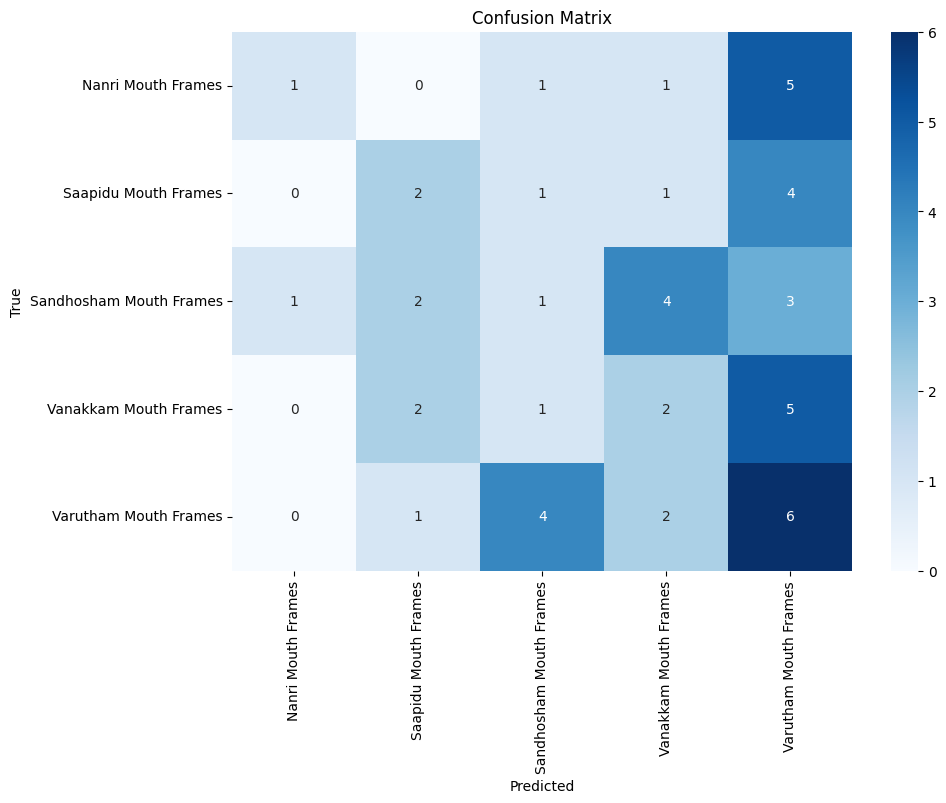

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation set
val_labels = validation_generator.classes
val_preds = model.predict(validation_generator)
val_preds = np.argmax(val_preds, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
print('Confusion Matrix:\n', conf_matrix)

# Classification Report
print('Classification Report:\n', classification_report(val_labels, val_preds, target_names=list(train_generator.class_indices.keys())))

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(train_generator.class_indices.keys()), yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
